In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import time
import plotly.graph_objects as go

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class Network(nn.Module):

  def __init__(self, input, width, depth, output, N):
    super().__init__()
    
    

    
    # constants and stuff
    self.r_rms = self.rms_sample(N)[0]
    self.t_rms = self.rms_sample(N)[1]
    self.c_numerical = torch.tensor(self.NumericalSoln(self.r_rms.cpu().detach().numpy(), self.t_rms.cpu().detach().numpy())).to(device)
    self.N = N
    self.r0_boundary, self.rs_boundary, self.t_boundaries, self.t0_boundary, self.r_boundary = self.init_boundaries(N)
    self.j = -5.35e-5
    self.Rs = 2e-6
    self.c_max = 4.665e4
    self.c0 = torch.tensor(2e4).view(-1, 1).to(device)
    self.D_ref = 2e-16

    # storing D and loss values
    self.loss_list = []

    # activation function
    activation = nn.ReLU

    # input layer
    self.fci = nn.Sequential(*[nn.Linear(input, depth), activation()])

    # hidden layers
    self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(depth, depth), activation()]) for i in range(width-1)])

    # output layer
    self.fco = nn.Linear(depth, output)

    self.optimizer_lbfgs = torch.optim.LBFGS(self.parameters(), 
                                    max_iter=100,
                                    history_size=100,
                                    tolerance_grad=1.0 * np.finfo(float).eps, 
                                    tolerance_change=1.0 * np.finfo(float).eps,
                                    line_search_fn='strong_wolfe')
  # forward propagation
  def forward(self, x, t):
    x = torch.cat((x, t), dim = 1)
    x = self.fci(x)
    x = self.fch(x)
    x = self.fco(x)
    c = x[:, 0]
    D = x[:, 1]
    return c, D
  
  # numerical solution of spherical diffusion equation
  def NumericalSoln(self, r_rms, t_rms):

    numerical_sol = pd.read_csv("MATLAB Solver\data.csv")
    
    sol = []
    for i in range(len(r_rms)):
      r = np.round(10000 * r_rms[i]).astype(int)[0]
      t = np.round(400 * t_rms[i]).astype(int)[0]  
      
      c = numerical_sol.iloc[r, t]
      sol.append(c)
    return sol
  
  def init_boundaries(self, N):

    # x and t boundary points for training x boundaries, x = 0,1, varying t values
    r0_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True).to(device)
    rs_boundary = torch.tensor(1.).view(-1, 1).requires_grad_(True).to(device)
    t_boundaries = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)

    # 0 time boundary for training
    t0_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True).to(device)
    r_boundary = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)

    return r0_boundary, rs_boundary, t_boundaries, t0_boundary, r_boundary
  
  def physics_sample(self, N):
      
      # sample points for training
      r = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)
      t = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)
  
      return r, t
  
  def rms_sample(self, N):
        
        # sample points for training
        r = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)
        t = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)
    
        return r, t
  
  def Diffusion_Coeff(self, c, D_ref):
    # constants
    #D_ref = 2e-16
    c_max = 4.665e4
    C_theory = 277.84
    C_practical = 160

    # equations
    SOC = (c_max - c*c_max)/c_max * C_theory/C_practical
    D = D_ref * (1 + 100*SOC**(3/2))

    return D
  
  def c_r(self, c, r):
    return torch.autograd.grad(c, r, grad_outputs=torch.ones_like(c).to(device), create_graph=True)[0]
  
  def c_rr(self, c, r):
    c_r = self.c_r(c, r)
    return torch.autograd.grad(c_r, r, grad_outputs=torch.ones_like(c_r).to(device), create_graph=True)[0]
  
  def c_t(self, c, t):
    return torch.autograd.grad(c, t, grad_outputs=torch.ones_like(c).to(device), create_graph=True)[0]

  def losses(self):
 
    r_phys, t_phys = self.physics_sample(self.N)
    j, Rs, c_max, c0 = self.j, self.Rs, self.c_max, self.c0
    

    # loss for r = 0 boundary
    r0_loss = torch.empty(0).to(device)
    for t in self.t_boundaries:
      t = t.unsqueeze(1)
      c, _ = self.forward(self.r0_boundary, t)
      c_r = self.c_r(c, self.r0_boundary)
      r0_loss = torch.cat((r0_loss, c_r**2), 0)
    
    # loss for x = rs boundary
    rs_loss = torch.empty(0).to(device)
    for t in self.t_boundaries:
      t = t.unsqueeze(1)
      c, Ds = self.forward(self.rs_boundary, t)
      c_r = self.c_r(c, self.rs_boundary)
      
      
      rs_loss = torch.cat((rs_loss, (Ds*1e-16*c_r + j*Rs/c_max)**2), 0)
    
    # loss for t0 boundary
    t0_loss = torch.empty(0).to(device)
    for r in self.r_boundary:
      r = r.unsqueeze(1)
      c, _ = self.forward(r, self.t0_boundary)
      t0_loss = torch.cat((t0_loss, (c_max*c - c0)**2), 0)

    # physics loss
    phys_loss = torch.empty(0).to(device)
    for i in range(len(r_phys)):

      r = r_phys[i].view(-1, 1)
      t = t_phys[i].view(-1, 1)

      c, Ds = self.forward(r, t)
      c_r = self.c_r(c, r)
      c_rr = self.c_rr(c, r)
      c_t = self.c_t(c, t)

      phys_loss = torch.cat((phys_loss, (r**2*c_t - 2*r*Ds*1e-16/Rs**2*c_r - r**2*Ds*1e-16/Rs**2*c_rr)**2), 0)
    
    rms_loss = torch.empty(0).to(device)
    for i in range(len(self.r_rms)):
      c, _ = self.forward(self.r_rms[i].view(-1, 1), self.t_rms[i].view(-1, 1))
      rms_loss = torch.cat((rms_loss, (c_max*c - self.c_numerical[i])**2), 0)
    
    #print(torch.mean(r0_loss).item(), torch.mean(rs_loss).item(), torch.mean(t0_loss).item(), torch.mean(phys_loss).item(), torch.mean(rms_loss).item(), end='\r')
    loss = 1e-3 * (torch.mean(r0_loss) + torch.mean(rs_loss) + torch.mean(phys_loss)) + torch.mean(rms_loss) + torch.mean(t0_loss)

    # store loss and D values
    self.loss_list.append(loss.item())
   

    return loss
  
  def closure(self):
    self.optimizer_lbfgs.zero_grad()
    loss = self.losses()
    loss.backward()
    return loss
  
  def train(self, epochs_adam, lr_adam, epochs_lbfgs):

    optimizer = torch.optim.Adam(self.parameters(), lr = lr_adam)

    for epoch in range(epochs_adam):
      
      optimizer.zero_grad()
      # find loss
      loss = self.losses()

      # backpropagation
      loss.backward()
      optimizer.step()
      # print loss and parameter values
      print(f'Epoch: {epoch}  Loss: {loss.item()}', end='\r')

    for epoch in range(epochs_lbfgs):
      
      self.optimizer_lbfgs.step(self.closure)
      print(f'Epoch: {epochs_adam + epoch}  Loss: {self.loss_list[-1]}', end='\r')

    self.plot()
    self.plot_comparison()
    self.plot_loss()

    return self.losses
  


  def plot(self):
      
      c_max = self.c_max
      X = torch.linspace(0, 1, 100).to(device)
      T = torch.linspace(0, 1, 100).to(device)
      
      C = np.zeros((len(X), len(T)))
      D = np.zeros((len(X), len(T)))
      for i in range(len(X)):
        x = X[i].view(-1, 1)
        for j in range(len(T)):
          t = T[j].view(-1, 1)
          c, d = self.forward(x, t)
          C[i, j] = c_max * c.item()
          D[i, j] = d.item() 
      
      X, T = np.meshgrid(X.cpu().detach().numpy(), T.cpu().detach().numpy())
      fig = go.Figure(data=[go.Surface(z=C, x=5e-6*X, y=400*T, colorscale='viridis')])
      fig.update_layout(scene=dict(aspectratio=dict(x=1, y=1, z=0.7), xaxis_title='X', yaxis_title='T', zaxis_title='C'))
      fig.show()

      C_flat = C.flatten()
      D_flat = D.flatten()

      fig1 = go.Figure(data=[go.Scatter(x=C_flat, y=D_flat, mode='markers')])
      fig1.show()
      
      



  def plot_loss(self):

    plt.figure()
    plt.plot(self.loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.show()

  def plot_comparison(self):
    
    c_max = self.c_max
    numerical = pd.read_csv("MATLAB Solver\data.csv")
    X = torch.linspace(0, 1, 100).to(device)
    T = torch.linspace(0, 1, 100).to(device)
    
    C = np.zeros((len(X), len(T)))
    for i in range(len(X)):
      x = X[i].view(-1, 1)
      for j in range(len(T)):
        t = T[j].view(-1, 1)
        c, _ = self.forward(x, t)
        C[i, j] = c_max * c.item()
    

    X = 10000*X.cpu().detach().numpy()
    T = 400*T.cpu().detach().numpy()
    
    fig, axs = plt.subplots(2, 2, figsize=(8, 6))

    axs[0, 0].plot(numerical.iloc[:, 0])
    axs[0, 0].plot(X, C[..., 0])
    axs[0, 0].legend(['Numerical', 'NN'])
    axs[0, 0].set_title('Comparison at t=0')

    axs[0, 1].plot(numerical.iloc[:, -1])
    axs[0, 1].plot(X, C[:, -1])
    axs[0, 1].legend(['Numerical', 'NN'])
    axs[0, 1].set_title('Comparison at t=end')

    axs[1, 0].plot(numerical.iloc[0, :])
    axs[1, 0].plot(T, C[0, :])
    axs[1, 0].legend(['Numerical', 'NN'])
    axs[1, 0].set_title('Comparison at r=0')

    axs[1, 1].plot(numerical.iloc[-1, :]) 
    axs[1, 1].plot(T, C[-1, :])
    axs[1, 1].legend(['Numerical', 'NN'])
    axs[1, 1].set_title('Comparison at r=end')

    plt.tight_layout()
    plt.show()
    
    plt.legend(['Numerical', 'NN'])

    


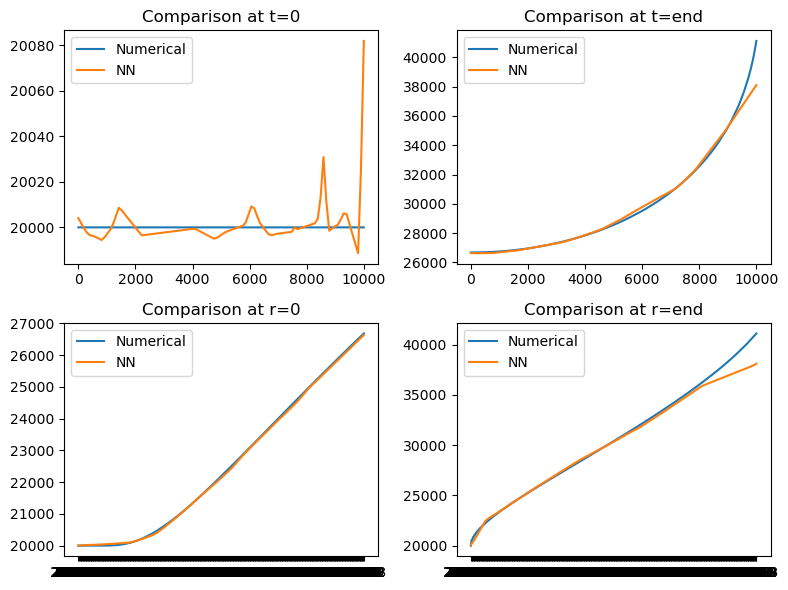

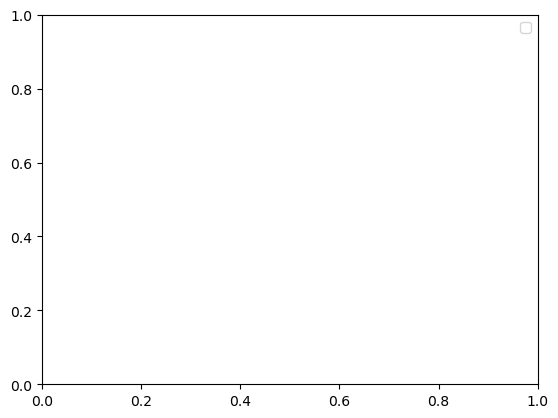

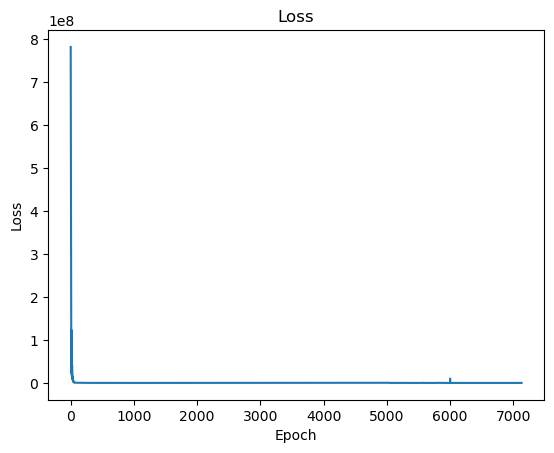

In [4]:
# nn seed
torch.manual_seed(938)
device = 'cpu'
N = 100
epochs_adam = 6000
lr_adam = 1e-3
epochs_lbfgs = 150


# define nn to train, two inputs for x and t
pinn = Network(2, 5, 128, 2, N).to(device)





losses = pinn.train(epochs_adam, lr_adam, epochs_lbfgs)


In [ ]:
pinn.plot()

NameError: name 'losses' is not defined

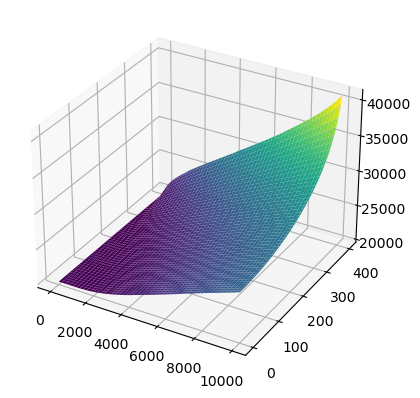

In [132]:
numerical = pd.read_csv("MATLAB Solver\data.csv")

X = np.round(10000 * np.linspace(0, 0.999, 100), 0)
T = np.round(400 * np.linspace(0, 0.999, 100), 0)


    
C = np.zeros((len(X), len(T)))
for i in range(len(X)):
    x = int(X[i])
    for j in range(len(T)):
        t = int(T[j]) 
        C[i, j] = numerical.iloc[x, t]
    
X, T = np.meshgrid(X, T)
fig = plt.figure()
fig.clear()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, C, cmap='viridis')
      
plt.show()




In [7]:
def train_and_time(network_size, epochs, lr, N, device):
    torch.manual_seed(938)

    # Define the NN
    pinn = Network(2, *network_size, 1).to(device)

    # Training
    start_time = time.time()
    Ds, losses = pinn.train(epochs, lr, N)
    end_time = time.time()
    elapsed_time = end_time - start_time

    return elapsed_time

# Set up parameters
epochs = 3000
lr = 1e-3
N = 100

# Define network sizes to test
network_sizes = [
    (3, 32),
    (5, 32),
    (3, 128),
    (5, 128), 
    (5, 256), 
    (10, 256),
        
]

# Set random seed for reproducibility
torch.manual_seed(938)

elapsed_time_cpu = []
elapsed_time_gpu = []
# Train and time for each network size
for i in range(len(network_sizes)):
    size = network_sizes[i]
    elapsed_time_cpu.append = train_and_time(size, epochs, lr, N, 'cpu')
    elapsed_time_gpu.append = train_and_time(size, epochs, lr, N, 'cuda')

# Plot the results
plt.figure()
plt.plot(network_sizes, elapsed_time_cpu, label='CPU')
plt.plot(network_sizes, elapsed_time_gpu, label='GPU')
plt.xlabel('Network size')
plt.ylabel('Time (s)')
plt.legend()
plt.show()


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)